In [12]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()



In [13]:
train = pd.read_csv("C:\\Users\\dell\\Desktop\\bitcoin train.csv", index_col="Date")
test = pd.read_csv("C:\\Users\\dell\\Desktop\\bitcoin test.csv", index_col="Date")

In [14]:
train = train[::-1]
test = test[::-1]

In [15]:
train.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [16]:
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')

In [17]:
from sklearn.preprocessing import StandardScaler
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)


In [18]:
print(train_n.shape)
print(test_n.shape)

(1556, 1)
(7, 1)


In [19]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

In [20]:
lookback = 24
step = 1
delay = 7
batch_size = 128
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)
val_steps = (len(train_n) - 1001 - lookback) // batch_size
test_steps = (len(test_n) - lookback) // batch_size

In [21]:
np.random.seed(7)

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [23]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, train_n.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 6s 58ms/step - loss: 0.1803 - val_loss: 0.4318
Epoch 2/20
100/100 [==============================] - 2s 25ms/step - loss: 0.1546 - val_loss: 0.4326
Epoch 3/20
100/100 [==============================] - 2s 24ms/step - loss: 0.1511 - val_loss: 0.4016
Epoch 4/20
100/100 [==============================] - 3s 25ms/step - loss: 0.1532 - val_loss: 0.4151
Epoch 5/20
100/100 [==============================] - 2s 23ms/step - loss: 0.1502 - val_loss: 0.4255
Epoch 6/20
100/100 [==============================] - 2s 24ms/step - loss: 0.1516 - val_loss: 0.4575
Epoch 7/20
100/100 [==============================] - 2s 23ms/step - loss: 0.1475 - val_loss: 0.4730
Epoch 8/20
100/100 [==============================] - 3s 25ms/step - loss: 0.1467 - val_loss: 0.4678
Epoch 9/20
100/100 [==============================] - 2s 24ms/step - loss: 0.1410 - val_loss: 0.4382
Epoch 10/20
100/100 [==============================] - 2s 22ms/step - loss: 0.1321 - val_lo

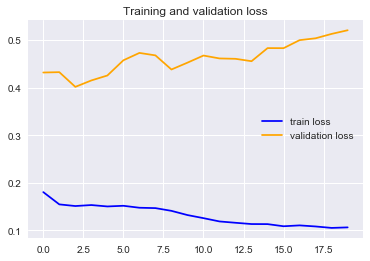

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'blue', label='train loss')
plt.plot(epochs, val_loss, 'orange', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [26]:
train_re = train_n.reshape(-1,1,1)
pred = model.predict(train_re)

In [27]:
pred = scaler.inverse_transform(pred)

Text(0.5,1,'Forecasting Results')

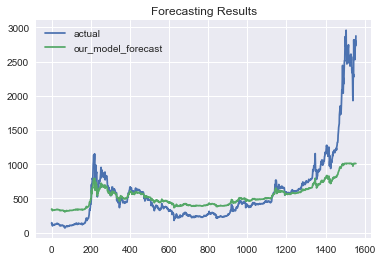

In [31]:
plt.plot(range(len(train_re)), train, label='actual')
plt.plot(range(len(train_re)), pred, label='our_model_forecast')
plt.legend()

plt.title("Forecasting Results")